# GCLS_Healthcare

### Team Members: 
* Sanket Jain [sanket.jain@plaksha.org]
* Vinay Neekhra [vinay.neekhra@plaksha.org]
* Nikita Arora [nikita.arora@plaksha.org]
* Neha Gupta [neha.gupta@plaksha.org]
* Susmeet Jain [susmeet.jain@plaksha.org]


Project Aim: To predict "Gestational Age" of 3 women based on the 7 multi-omics high-dimensional datasets. Training data consist of 14 women.
More details can be found here: https://github.com/rintukutum/challengeLab-ML
      
<img src= "https://raw.githubusercontent.com/rintukutum/challengeLab-ML/master/figures/figure-01.png">

# Observations and Results

1. Number of featres much more than number of samples so simple models like LinearRegression and RandomForests tried.
2. For some records, Gestational Age is negative which is difficult for the model to predict. Because of lack of domain knowledge, it is considered as is.
3. Some datasets had more than 50000 features. Feature selection was performed for such cases, removing features on the basis of variance and correlation, and selecting top 100 features. The results didn't degrade by much, signifying that majority of the features are irrelevant and exhibit low correlation with the target.
4. Mean Absolute Error comes out to be 3.2, 2.9, 1.4 years for the 3 parts respectively.
5. This reveals that individually datasets in parts 1 and 2 don't perform that well and it is the combination of both of these that leads to good results. 


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest

In [2]:
import pathlib
import os

comp_path = os.path.normpath(pathlib.Path().absolute())+os.path.normpath("/challengeLab-ML/data/train/")


## Part-1

In [3]:

sub_cl1_file_names = "immunome,SerumLuminex,plasmaLuminex,plasmaSomalogic".split(",")
sub_cl1_file_names = [x+".csv" for x in sub_cl1_file_names]
sub_cl1_file_names


['immunome.csv',
 'SerumLuminex.csv',
 'plasmaLuminex.csv',
 'plasmaSomalogic.csv']

In [4]:
df_immunome = pd.read_csv(os.path.join(comp_path,sub_cl1_file_names[0])) #68*535
df_SerumLuminex = pd.read_csv(os.path.join(comp_path,sub_cl1_file_names[1]))
df_plasmaLuminex = pd.read_csv(os.path.join(comp_path,sub_cl1_file_names[2]))
df_plasmaSomalogic = pd.read_csv(os.path.join(comp_path,sub_cl1_file_names[3])) #1301 features!

df_immunome["SampleID"].unique().shape  #File has unique SampleID

df_immunome = df_immunome.sort_values(by="SampleID",axis=0,kind="mergesort")
df_SerumLuminex = df_SerumLuminex.sort_values(by="SampleID",axis=0,kind="mergesort")
df_plasmaLuminex = df_plasmaLuminex.sort_values(by="SampleID",axis=0,kind="mergesort")
df_plasmaSomalogic = df_plasmaSomalogic.sort_values(by="SampleID",axis=0,kind="mergesort")

In [5]:
df_cl1 = pd.concat([df_immunome,df_SerumLuminex.iloc[:,1:],df_plasmaLuminex.iloc[:,1:],df_plasmaSomalogic.iloc[:,1:]],axis=1)

In [10]:
np.any(pd.isna(df_cl1))
#No Null values in any file

False

In [11]:
df_immunome.dtypes[1:].unique() #All columns float except the first one

array([dtype('float64')], dtype=object)

In [6]:
%cd "challengeLab-ML/data/"
targets_df = pd.read_csv("challenge-meta-information.csv")


C:\Users\Lenovo\Desktop\Plaksha Course Material\Healthcare\challengeLab-ML\data


In [14]:
targets_df

,time,GA,SampleID,randPerson,data
0,1,11.000000,K1,K,train
1,1,11.000000,J1,J,train
2,1,11.000000,P1,P,train
3,1,11.000000,L1,L,train
4,1,11.000000,H1,H,train
...,...,...,...,...,...
63,3,27.000000,W3,W,test
64,3,27.000000,B3,B,test
65,4,2.571429,I4,I,test
66,4,0.571429,W4,W,test


(array([13.,  4.,  1., 16., 16.,  1., 11.,  6.]),
 array([-3.42857143,  1.        ,  5.42857143,  9.85714286, 14.28571429,
        18.71428571, 23.14285714, 27.57142857, 32.        ]),
 <a list of 8 Patch objects>)

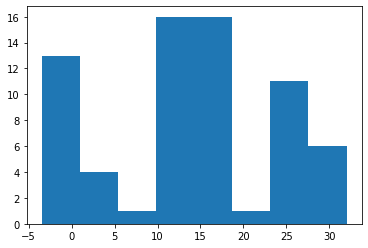

In [188]:
plt.hist(targets_df["GA"],bins="auto")



As can be seen, significant proportion of the dataset has negative gestational age which is inaccurate. Since we are not removing any rows from the dataset, these records will result in some error in the model's predictions.

In [7]:
targets_df["randPerson"].unique().shape
#Total 17 women, each observed 4 times

targets_df = targets_df[["GA","SampleID","data"]]


In [17]:
df_cl1.head()

,SampleID,Bcells,CD16+CD56-NKcells,CD4+Tcells_mem,CD4+Tcells_naive,CD4+Tcells,CD45RA+Tregs,CD45RA-Tregs,CD56+CD16-NKcells,CD7+NKcells,...,ATP5O,POMC.2,CRYZL1,SERPINF1,CTSF,FTCD,USP25,PLXNB2,GA,data
0,K4,0.053164,0.054978,0.297875,0.136289,0.445832,0.002570,0.013848,0.007052,0.070836,...,3610.9,365.4,151.4,37885.8,1479.1,3261.8,561.3,3227.0,-0.428571,train
1,I4,0.137333,0.061311,0.274281,0.139593,0.422238,0.004931,0.013510,0.004393,0.075063,...,2679.9,370.1,191.8,32384.0,1557.6,1950.0,701.3,3179.1,2.571429,test
2,J4,0.103067,0.004128,0.162746,0.103950,0.270840,0.003198,0.007988,0.007153,0.090763,...,1470.6,410.8,163.0,38938.3,1170.1,1036.8,552.8,3457.1,-3.428571,train
3,P4,0.149802,0.058161,0.141881,0.257104,0.406758,0.013168,0.009568,0.002663,0.069008,...,2331.3,567.5,178.1,34359.5,1427.1,3149.2,597.0,3370.9,1.571429,train
4,L4,0.124177,0.037422,0.235283,0.132742,0.374535,0.003886,0.008935,0.001813,0.044584,...,2189.1,569.8,176.3,35281.1,1944.2,3266.7,615.2,2916.1,1.571429,train


In [8]:
df_cl1 = pd.merge(df_cl1,targets_df,on="SampleID",)#


In [9]:
sampleID = df_cl1.loc[df_cl1["data"]=="test","SampleID"].values
df_cl1 = df_cl1.iloc[:,1:].values


In [10]:
df_cl1_train = df_cl1[df_cl1[:,-1]=="train"][:,:-1] 
df_cl1_test = df_cl1[df_cl1[:,-1]=="test"][:,:-1]
#536 features, 1 label


In [11]:
scaling_transf = MinMaxScaler()
X_train = scaling_transf.fit_transform(df_cl1_train[:,:-1])
X_test = scaling_transf.transform(df_cl1_test[:,:-1])

y_train = df_cl1_train[:,-1]
y_test = df_cl1_test[:,-1]

In [12]:

#using MAE - quantile regression
regressor = SGDRegressor(loss="epsilon_insensitive",epsilon=0,penalty="l1",alpha=0.01,max_iter=300,eta0=0.01,power_t=0.25,learning_rate="invscaling",n_iter_no_change=6,verbose=1)
regressor.fit(X_train,y_train)


-- Epoch 1
Norm: 0.86, NNZs: 1804, Bias: 0.044849, T: 56, Avg. loss: 9.242831
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.01, NNZs: 1675, Bias: 0.045815, T: 112, Avg. loss: 8.132638
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.27, NNZs: 1642, Bias: 0.058096, T: 168, Avg. loss: 7.769284
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1.45, NNZs: 1580, Bias: 0.063230, T: 224, Avg. loss: 7.554133
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 1.53, NNZs: 1503, Bias: 0.058483, T: 280, Avg. loss: 7.150225
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 1.73, NNZs: 1482, Bias: 0.068065, T: 336, Avg. loss: 6.961548
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 1.88, NNZs: 1469, Bias: 0.072514, T: 392, Avg. loss: 6.555391
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 1.97, NNZs: 1395, Bias: 0.068073, T: 448, Avg. loss: 6.638495
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 2.15, NNZs: 1403, Bias: 0.076542, T: 504, Avg. loss: 6.337125
Total trai

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='epsilon_insensitive',
             max_iter=300, n_iter_no_change=6, penalty='l1', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=1, warm_start=False)

In [13]:
y_pred=regressor.predict(X_test)
mean_absolute_error(y_test,y_pred)


4.2481142886798615

LinearRegression doesn't work well, MAE of 4.27 yrs means it's not a very good model. Let's try an ensemble of models (RandomForest) where we will utilize the concept of bagging to make multiple "weak" models that make uncorrelated errors.


In [14]:
%cd C:\\Users\\Lenovo\\Desktop\\Plaksha Course Material\\Healthcare
    
final_df_sl1_lr = pd.DataFrame([sampleID,y_test,y_pred]).T
final_df_sl1_lr.columns = ["SampleID","Actual GA","Predicted GA"]
final_df_sl1_lr.to_csv("GROUP-11-SC1-LinearReg.csv")

C:\Users\Lenovo\Desktop\Plaksha Course Material\Healthcare


In [42]:

#50 estimators, leaves contain less than 2 samples, division only when 1 sample in leaves, boostrap ON but all samples,
#see only sqrt(features) 

rfRegressor = RandomForestRegressor(n_estimators=100,criterion="mae",min_samples_split=2,min_samples_leaf=1,bootstrap=True,n_jobs=-1,verbose=1) #max_features="auto"
rfRegressor.fit(X_train,y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [43]:
y_pred=rfRegressor.predict(X_train)

print(mean_absolute_error(y_train,y_pred))


y_pred=rfRegressor.predict(X_test)
print(mean_absolute_error(y_test,y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


1.6157908163265298
3.6396428571428565


MAE of 3.2 is significantly better than the earlier 4.2. 

In [44]:
%cd C:\\Users\\Lenovo\\Desktop\\Plaksha Course Material\\Healthcare
    
final_df_sl1_lr = pd.DataFrame([sampleID,y_test,y_pred]).T
final_df_sl1_lr.columns = ["SampleID","Actual GA","Predicted GA"]
final_df_sl1_lr.to_csv("GROUP-11-SC1-RF.csv")


C:\Users\Lenovo\Desktop\Plaksha Course Material\Healthcare


## Part-2

In [3]:
sub_cl2_file_names = "cfRNA,metabolome,microbiome".split(",")
sub_cl2_file_names = [x+".csv" for x in sub_cl2_file_names]
sub_cl2_file_names


['cfRNA.csv', 'metabolome.csv', 'microbiome.csv']

In [4]:
df_cfRNA = pd.read_csv(os.path.join(comp_path,sub_cl2_file_names[0])) 
df_metabolome = pd.read_csv(os.path.join(comp_path,sub_cl2_file_names[1]),encoding="iso-8859-1")
df_microbiome = pd.read_csv(os.path.join(comp_path,sub_cl2_file_names[2]))


df_cfRNA = df_cfRNA.sort_values(by="SampleID",axis=0,kind="mergesort")
df_metabolome = df_metabolome.sort_values(by="SampleID",axis=0,kind="mergesort")
df_microbiome = df_microbiome.sort_values(by="SampleID",axis=0,kind="mergesort")


In [19]:
df_cl2 = pd.concat([df_cfRNA,df_metabolome.iloc[:,1:],df_microbiome.iloc[:,1:]],axis=1)
df_cl2 =pd.merge(df_cl2,targets_df,on="SampleID",) #.values

In [20]:
sampleID = df_cl2.loc[df_cl2["data"]=="test","SampleID"].values
df_cl2 = df_cl2.iloc[:,1:]


In [9]:
df_cl2
#59308 features now!

,C2orf76,ACTL10,CEP135,RP11-613M10.6,NDUFB5P1,MIIP,RP11-98I9.4,C20orf144,RP11-485G7.6,CCDC86,...,ToothGum_Sphingomonas.5,Stool_Sphingomonas.5,VaginalSwab_Thalassospira.9,Saliva_Thalassospira.9,ToothGum_Thalassospira.9,Stool_Thalassospira.9,time,GA,randPerson,data
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.034209,-0.034209,-0.034209,-0.034209,-0.034209,-0.034209,1,11.000000,B,test
1,0.000000,0.0,34.022863,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.034891,-0.034891,-0.034891,-0.034891,-0.034891,-0.034891,2,16.000000,B,test
2,0.000000,0.0,97.646714,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.025123,-0.025123,-0.025123,-0.025123,-0.025123,-0.025123,3,27.000000,B,test
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.034209,-0.034209,-0.034209,-0.034209,-0.034209,-0.034209,4,0.571429,B,test
4,2.126079,0.0,86.106183,0.0,0.0,12.756472,1.063039,0.000000,0.0,11.693432,...,-0.024750,-0.024750,-0.024750,-0.024750,-0.024750,-0.024750,1,8.000000,G,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,35.254263,0.0,3.204933,0.0,0.0,9.614799,0.000000,0.000000,0.0,16.024665,...,-0.026713,-0.026713,-0.026713,-0.026713,-0.026713,-0.026713,4,0.571429,W,test
64,0.000000,0.0,10.638411,0.0,0.0,74.468877,0.000000,0.000000,0.0,0.000000,...,-0.023462,-0.023462,-0.023462,-0.023462,-0.023462,-0.023462,1,10.000000,X,train
65,0.000000,0.0,0.000000,0.0,0.0,70.901872,0.000000,0.000000,0.0,0.000000,...,-0.022884,-0.022884,-0.022884,-0.022884,-0.022884,-0.022884,2,19.000000,X,train
66,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.026088,-0.026088,-0.026088,-0.026088,-0.026088,-0.026088,3,31.000000,X,train


In [21]:
df_cl2_train = df_cl2[df_cl2.iloc[:,-1]=="train"].iloc[:,:-1] 
df_cl2_test = df_cl2[df_cl2.iloc[:,-1]=="test"].iloc[:,:-1]

#df_cl2_train = df_cl2_train[:,:-1]
#df_cl2_test = df_cl2_test[:,:-1]


In [18]:
targets_df

,GA,SampleID,data
0,11.000000,K1,train
1,11.000000,J1,train
2,11.000000,P1,train
3,11.000000,L1,train
4,11.000000,H1,train
...,...,...,...
63,27.000000,W3,test
64,27.000000,B3,test
65,2.571429,I4,test
66,0.571429,W4,test


In [17]:


def correlation(dataset, test_dataset, threshold=0.9):
    col_corr = set() # Set of all the names of deleted columns
    dataset = dataset.astype(np.float32)
    #corr_matrix = dataset.iloc[:,:-1].corr() #ignoring the target column

    for i in range(len(dataset.columns)-1):
        for j in range(i):
            if (dataset.columns[j] not in col_corr) and (abs(np.corrcoef(dataset.iloc[:,i],dataset.iloc[:,j])[0][1]) >= threshold):
                colname = dataset.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    del test_dataset[colname]

    return dataset,test_dataset

#df_cl2_train,df_cl2_test = correlation(df_cl2_train,df_cl2_test)


In [22]:

vars = VarianceThreshold()
df_cl2_train = vars.fit_transform(df_cl2_train.values)
df_cl2_test = vars.transform(df_cl2_test.values)


In [23]:
#536 features, 1 label

scaling_transf = MinMaxScaler()
X_train = scaling_transf.fit_transform(df_cl2_train[:,:-1])
X_test = scaling_transf.transform(df_cl2_test[:,:-1])

y_train = df_cl2_train[:,-1]
y_test = df_cl2_test[:,-1]

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [24]:
bestFeatures=SelectKBest(f_regression, k=1000)
X_train = bestFeatures.fit_transform(X_train, y_train)
X_test = bestFeatures.transform(X_test)


In [25]:

rfRegressor = RandomForestRegressor(n_estimators=100,criterion="mae",min_samples_split=2,min_samples_leaf=1,bootstrap=False,n_jobs=-1,verbose=1) #
rfRegressor.fit(X_train,y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished


RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [26]:
y_pred = rfRegressor.predict(X_test)
mean_absolute_error(y_test,y_pred)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


2.6608333383961793

In [27]:
y_pred = rfRegressor.predict(X_train)
mean_absolute_error(y_train,y_pred)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.0

In [28]:
%cd C:\\Users\\Lenovo\\Desktop\\Plaksha Course Material\\Healthcare
    
final_df_sl1_lr = pd.DataFrame([sampleID,y_test,y_pred]).T
final_df_sl1_lr.columns = ["SampleID","Actual GA","Predicted GA"]
final_df_sl1_lr.to_csv("GROUP-11-SC2-RF.csv")


C:\Users\Lenovo\Desktop\Plaksha Course Material\Healthcare


## Part-3

In [31]:
sub_cl3_file_names = sub_cl1_file_names+sub_cl2_file_names
sub_cl3_file_names


['immunome.csv',
 'SerumLuminex.csv',
 'plasmaLuminex.csv',
 'plasmaSomalogic.csv',
 'cfRNA.csv',
 'metabolome.csv',
 'microbiome.csv']

In [34]:

df_cl3 = pd.concat([df_cfRNA,df_metabolome.iloc[:,1:],df_microbiome.iloc[:,1:],df_immunome.iloc[:,1:],df_SerumLuminex.iloc[:,1:],df_plasmaLuminex.iloc[:,1:],df_plasmaSomalogic.iloc[:,1:]],axis=1)


In [35]:
df_cl3 =pd.merge(df_cl3,targets_df,on="SampleID",) #.values


In [36]:
sampleID = df_cl3.loc[df_cl3["data"]=="test","SampleID"].values
df_cl3 = df_cl3.iloc[:,1:]


In [37]:
df_cl3_train = df_cl3[df_cl3.iloc[:,-1]=="train"].iloc[:,:-1] 
df_cl3_test = df_cl3[df_cl3.iloc[:,-1]=="test"].iloc[:,:-1]


In [38]:

vars = VarianceThreshold()
df_cl3_train = vars.fit_transform(df_cl3_train.values)
df_cl3_test = vars.transform(df_cl3_test.values)


In [39]:
#536 features, 1 label

scaling_transf = MinMaxScaler()
X_train = scaling_transf.fit_transform(df_cl3_train[:,:-1])
X_test = scaling_transf.transform(df_cl3_test[:,:-1])

y_train = df_cl3_train[:,-1]
y_test = df_cl3_test[:,-1]

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [40]:
bestFeatures=SelectKBest(f_regression, k=1000)
X_train = bestFeatures.fit_transform(X_train, y_train)
X_test = bestFeatures.transform(X_test)


In [43]:

rfRegressor = RandomForestRegressor(n_estimators=100,criterion="mae",min_samples_split=2,min_samples_leaf=1,bootstrap=False,n_jobs=-1,verbose=1) #
rfRegressor.fit(X_train,y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [44]:
y_pred = rfRegressor.predict(X_test)
mean_absolute_error(y_test,y_pred)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


1.5241666648714316

In [469]:
y_pred = rfRegressor.predict(X_train)
mean_absolute_error(y_train,y_pred)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.0

In [45]:
%cd C:\\Users\\Lenovo\\Desktop\\Plaksha Course Material\\Healthcare
    
final_df_sl1_lr = pd.DataFrame([sampleID,y_test,y_pred]).T
final_df_sl1_lr.columns = ["SampleID","Actual GA","Predicted GA"]
final_df_sl1_lr.to_csv("GROUP-11-SC3-RF.csv")


C:\Users\Lenovo\Desktop\Plaksha Course Material\Healthcare
